In [45]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Force analysis of ActuAtor

Summary of protocol for estimating forces on the membrane. Nuclei were traced from the EM images manually using Fiji. Assuming the Helfrich-Canham-Evans and surface energy of the membrane,

$$E =  \underbrace{\int_\Omega \kappa_b H^2 dA}_{E_b} + \underbrace{\int_\Omega \sigma dA}_{E_\sigma},$$

where $\kappa_b$ is the bending modulus, $H$ is the mean curvature given by the two principal curvatures, $(k_1 + k_2)/2$,  $\sigma$ is the prescribed constant surface tension, and $dA$ the area element. Given that the segmented EM images are plane curves, we assume naively that the out of plane principal curvature is naught ($k_2 = 0$). Rewriting as an energy density (per length) and simplifying,

$$\frac{E_b}{l} =\frac{\kappa_b}{4} \int_C k_1^2 ds,$$

and 

$$\frac{E_\sigma}{l} =  \sigma \int_C ds,$$ 


where $l$ is the depth relating the integrals over area, $\Omega$, and the plane curve, $C$; $ds$ is the arc-length element. To obtain the areal force density $f$ such that $f ds = -\nabla (E/l)$, we use automatic differentiation using `jax`. Note that $f$ is independent of the length scale $l$.  

## Analysis

In [46]:
from collections import defaultdict

from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from jax import jit
from jax.config import config

config.update("jax_enable_x64", True)

import automembrane.util as u
from automembrane.energy import ClosedPlaneCurveMaterial
from automembrane.geometry import ClosedPlaneCurveGeometry

from actuator_constants import *

import automembrane.plot_helper as ph

ph.matplotlibStyle(small=10, medium=12, large=14)


Assuming bending modulus $1\times10^{-19}$ J and modest membrane tension $0.05$ mN/m.

In [47]:
import numpy as np

parameters = {
    "Kb": 0.1 / 4,  # Bending modulus (pN um; original 1e-19 J)
    "Ksg": 50,  # Global stretching modulus (pN um/um^2; original 0.05 mN/m)
    "Ksl": 1,
}

mem = ClosedPlaneCurveMaterial(**parameters)

We iterate over the segmentations. To ensure that the discrete curves are sufficiently sampled, we parameterize the curve using a B-spline and resample evenly. We perform `n_iter` steps of forward Euler energy relaxation to smooth out artifacts of the discretization. We choose the sum of half the length of each incident edge to be the dual length, $ds_i$, of the $i^{\text{th}}$ vertex, $v_i$.

In [79]:
data = defaultdict(dict)

for file in files:
    k = file.stem
    print("Processing:", k)
    d = np.load(f"relaxed_coords/{k}.npz")

    data[k]["original_coords"] = d["original_coords"]
    data[k]["relaxed_coords"] = d["relaxed_coords"]

    dualLengths = ClosedPlaneCurveGeometry.vertex_dual_length(d["relaxed_coords"])
    data[k]["dualLengths"] = dualLengths

    data[k]["relaxed_forces"] = sum(mem.force(d["relaxed_coords"])) / dualLengths


Processing: 34D-grid2-s3-acta1_001_16
Processing: 34D-grid3-ActA1_007_16
Processing: 34D-grid3-ActA1_013_16
Processing: 34D-grid2-s2_002_16
Processing: 34D-grid2-s5_005_16
Processing: 34D-grid3-ActA1_020_16
Processing: 34D-grid3-s6_005_16
Processing: 34D-grid2-s3_028_16
Processing: 34D-grid3-ActA1_001_16
Processing: 34D-grid3-ActA1_002_16
Processing: 34D-grid3-ActA1_003_16
Processing: 34D-grid3-ActA1_004_16


Processing 34D-grid2-s3-acta1_001_16


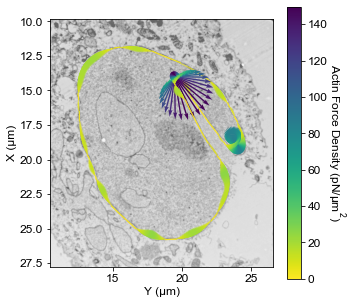

Processing 34D-grid3-ActA1_007_16


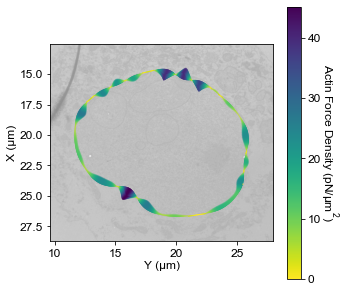

Processing 34D-grid3-ActA1_013_16


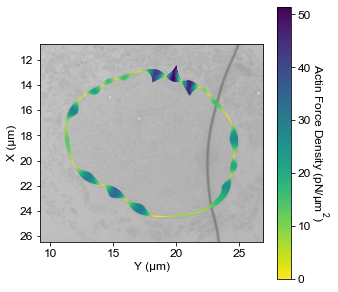

Processing 34D-grid2-s2_002_16


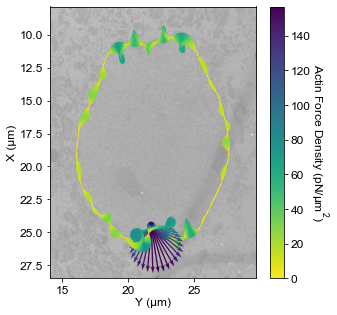

Processing 34D-grid2-s5_005_16


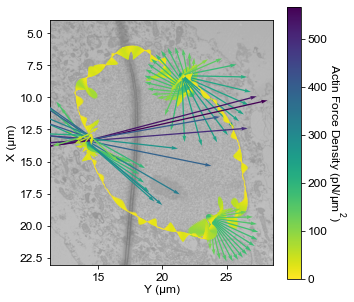

Processing 34D-grid3-ActA1_020_16


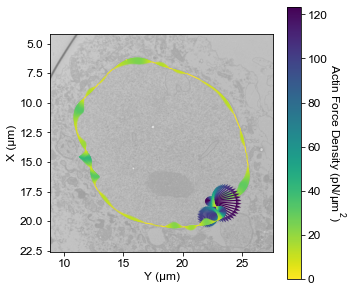

Processing 34D-grid3-s6_005_16


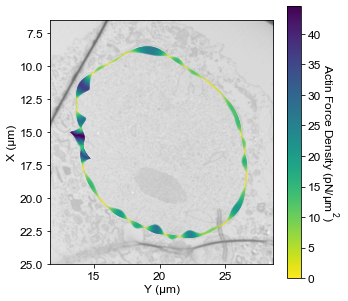

Processing 34D-grid2-s3_028_16


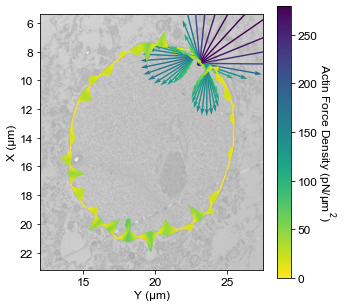

Processing 34D-grid3-ActA1_001_16


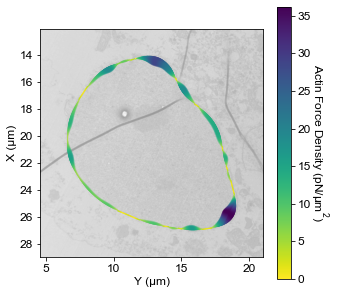

Processing 34D-grid3-ActA1_002_16


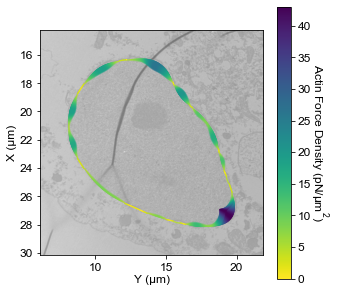

Processing 34D-grid3-ActA1_003_16


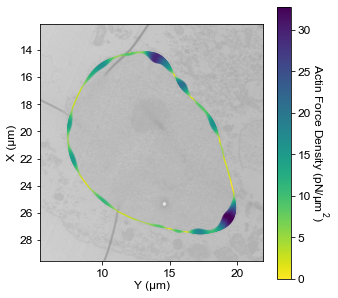

Processing 34D-grid3-ActA1_004_16


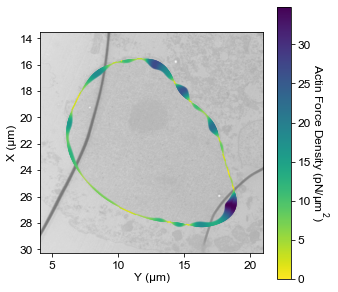

In [83]:
cm = mpl.cm.viridis_r
padding = 2  # padding to add around cell boundary to give broader image context

for file in files:
    k = file.stem
    d = data[k]
    print(f"Processing {k}")

    original_coords = d["original_coords"]
    relaxed_coords = d["relaxed_coords"]
    forces = d["relaxed_forces"]
    dualLengths = d["dualLengths"]
    f_mag = np.linalg.norm(forces, axis=1)

    norm = mpl.colors.Normalize(vmin=f_mag.min(), vmax=f_mag.max())
    # Map values to colors and add vertex color layer
    colors = cm(norm(f_mag))


    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    # ax.plot(original_coords[:, 0], original_coords[:, 1], color="r")
    # ax.plot(relaxed_coords[:, 0], relaxed_coords[:, 1], color="gray", zorder=1)
    ax.set_aspect('equal')

    # with Image.open(f"../crop_images/{k}.png") as im:
    with Image.open(f"../raw_images/{k}.TIF") as im:
        pixel_scale = images[k]


        x_lim = np.array([np.min(relaxed_coords[:, 0]), np.max(relaxed_coords[:, 0])]) + [
                -padding,
                padding,
            ]
        y_lim = np.array([np.min(relaxed_coords[:, 1]), np.max(relaxed_coords[:, 1])]) + [
            -padding,
            padding,
        ]
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)


        x_lim_pix = (x_lim / pixel_scale).round()
        y_lim_pix = (y_lim / pixel_scale).round()

        ax.set_ylim(ax.get_ylim()[::-1])

        im = im.crop((x_lim_pix[0], y_lim_pix[0], x_lim_pix[1], y_lim_pix[1]))

        plt.imshow(
            im,
            alpha=0.6,
            extent=(x_lim[0], x_lim[1], y_lim[1], y_lim[0]),
            zorder=0,
            cmap=plt.cm.Greys_r,
        )

    # vertex_normal = ClosedPlaneCurveGeometry.vertex_normal(relaxed_coords)
    # signed_f_mag = np.sum(forces * vertex_normal, axis=1)
    # signed_f_mag = signed_f_mag # / np.max(abs(signed_f_mag))
    # points = relaxed_coords.reshape(-1, 1, 2)

    # segments = np.concatenate([points[:-1], points[1:]], axis=1)
    # from matplotlib.collections import LineCollection
    
    # lc = LineCollection(segments, cmap="PRGn", norm=mpl.colors.CenteredNorm())
    # lc.set_array(signed_f_mag)
    # lc.set_linewidth(4)
    # line = ax.add_collection(lc)


    Q = ax.quiver(
        relaxed_coords[:, 0],
        relaxed_coords[:, 1],
        forces[:, 0],
        forces[:, 1],
        f_mag,
        cmap=cm,
        angles="xy",
        units="xy",
        label="force",
        scale=4e1,
        scale_units="xy",
        width=0.1,
        zorder=10,
    )
    ax.set_ylabel(r"X (μm)")
    ax.set_xlabel(r"Y (μm)")




    # Shrink current axis
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # cbar = fig.colorbar(line, ax=ax)
    # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    cbar = fig.colorbar(Q, ax=ax)
    cbar.ax.get_yaxis().labelpad = 20
    cbar.ax.set_ylabel("Actin Force Density ($\mathregular{pN/\mu m^2}$)", rotation=270)

    # Quiver key draws length of arrow
    # qk = ax.quiverkey(Q, 0.45, 0.8, 500, r'$500 \frac{pN}{\mu m^2}$', labelpos='E', coordinates='figure')

    plt.savefig(f"figures_new/{file.stem}_force.png")
    plt.show()


In [81]:
for file in files:
    k = file.stem
    d = data[k]

    original_coords = d["original_coords"]
    relaxed_coords = d["relaxed_coords"]
    forces = d["relaxed_forces"]
    f_mag = np.linalg.norm(forces, axis=1)
    dualLengths = d["dualLengths"]

    print(k)

    print(
        "Mean dual length:",
        np.mean(dualLengths),
        "μm;",
        np.mean(dualLengths) ** 2,
        "μm^2",
    )

    actin_force_density = 1.0 / 4.9e-5  # pN/um^2

    print("Actin force density:", actin_force_density, "pN/um^2")
    full_force = actin_force_density * np.mean(dualLengths) ** 2
    print("Full coverage force:", full_force, "pN")

    print(
        "Max force density:",
        np.max(f_mag),
        "pN/um^2;",
        "Max force:",
        np.max(f_mag) * np.mean(dualLengths) ** 2,
        "pN",
    )

    print("Coverage:", (np.max(f_mag) * np.mean(dualLengths) ** 2) / full_force * 100, "%")

    force_value = np.max(f_mag) * np.mean(dualLengths) ** 2
    print("Net Actin Force:", force_value, "pN")

    print("Total force on membrane:", np.sum(f_mag* np.mean(dualLengths**2)), "pN")
    print()


34D-grid2-s3-acta1_001_16
Mean dual length: 0.05631772151551155 μm; 0.003171685756698713 μm^2
Actin force density: 20408.163265306124 pN/um^2
Full coverage force: 64.72828074895332 pN
Max force density: 149.50561008817465 pN/um^2; Max force: 0.47418481406321494 pN
Coverage: 0.7325774894320558 %
Net Actin Force: 0.47418481406321494 pN
Total force on membrane: 43.215341330850926 pN

34D-grid3-ActA1_007_16
Mean dual length: 0.042130933944720214 μm; 0.001775015595054378 μm^2
Actin force density: 20408.163265306124 pN/um^2
Full coverage force: 36.22480806233425 pN
Max force density: 45.15530745670173 pN/um^2; Max force: 0.08015137493512081 pN
Coverage: 0.22126100653783845 %
Net Actin Force: 0.08015137493512081 pN
Total force on membrane: 25.244074740794687 pN

34D-grid3-ActA1_013_16
Mean dual length: 0.04044242532674504 μm; 0.0016355897663093485 μm^2
Actin force density: 20408.163265306124 pN/um^2
Full coverage force: 33.379382985905075 pN
Max force density: 51.41220638343438 pN/um^2; Max f

In [73]:
150*0.003

0.45

Assuming an actin filament is ~7nm in diameter a conservative surface area occupancy is 49 $\mathrm{nm^2}$ or 4.9e-5 $\mathrm{\mu m^2}$. Depending on cell conditions a single actin filament can produce ~1 pN of force.

Then 1pN * A / 4.9e-5 μm^2 gives the maximum force assuming full surface coverage by pushing actin.




# Non-dimensionalization
We first choose two scaling parameters bending rigidity $\kappa_b$ and curvature $C_0$ (close to the inverse of radius of the nuclei). First, we scale the coordinates of trace by $C_0$ before importing it into the energy evaluation. By fixing the dimensionless bending rigidity $\bar{\kappa_b} = 1$, we conduct parameter sweep on the nondimensional surface tension $\bar{\sigma} (\colonequals \frac{\sigma}{\kappa_b C_0^2} )$. The resultant force computed $\bar{f} = \frac{\bar{\nabla} \overline{(E/l)}}{d\bar{s}} $ is therefore also dimensionless. If needed, we can recover the force with unit by scaling it using the relationship $f = \kappa_b C_0^3 \bar{f} $.

We obtain the value for ${\kappa_b}$ from Lipowsky et al., 1991 and the range for ${\sigma}$ from Gautheir et al., 2012, while the length scale is approximately the radius of our cells.

Bending rigidity (${\kappa_b}$): $10^{-19} J$ or ${10^{-7}}$ $\mathrm{\frac{kg~{\mu m^2}}{s^2}}$

Surface tension (${\sigma}$): $0.01$ to $0.04$ $\mathrm{\frac{mN}{m}}$ or ${10^{-5}}$ to ${4~*~10^{-5}}$ $\mathrm{\frac{kg}{s^2}}$

Length scale: $5$ $\mathrm{\mu m}$

To non-dimensionalize the relationship between the bending rigidity, ${\kappa_b}$, and the surface tension, ${\sigma}$, we calculate the range of values for:

$$\mathrm{({\sigma}~*~{\frac{1}{\kappa_b}})~*~(length~scale){^2}}$$

Minimum:

$$\mathrm{{\frac{10^{-5}~kg}{1~{s^2}}}~*~{\frac{1~{s^2}}{10^{-7}~kg~\mu {m^2}}}~*~(5~\mu m){^2}~=~2500}$$

Maximum:

$$\mathrm{{\frac{4~*~10^{-5}~kg}{1~{s^2}}}~*~{\frac{1~{s^2}}{10^{-7}~kg~\mu {m^2}}}~*~(5~\mu m){^2}~=~10000}$$
